# Imports

In [112]:
# Estándar
from collections import Counter
import warnings
import time

# Núcleo científico
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix, precision_recall_curve
)

# Desbalanceo de clases
from imblearn.over_sampling import SMOTE

# Configuración global
warnings.filterwarnings("ignore")  # Silencia warnings innecesarios


# Preparación del dataset

In [3]:
# Leemos el archivo CSV con los datos
df = pd.read_csv('email_phishing_data.csv', delimiter=',')

# Mostramos el número de filas (entradas) y columnas (variables)
nRow, nCol = df.shape
print(f'Nº entradas: {nRow} , Nº columnas: {nCol} ')

# Distribución de la variable objetivo 'label'
dist_label = (
    df['label']
    .value_counts()
    .rename_axis('Clase')
    .reset_index(name='Frecuencia')
)

display(dist_label)

Nº entradas: 524846 , Nº columnas: 9 


,Clase,Frecuencia
0,0,517897
1,1,6949


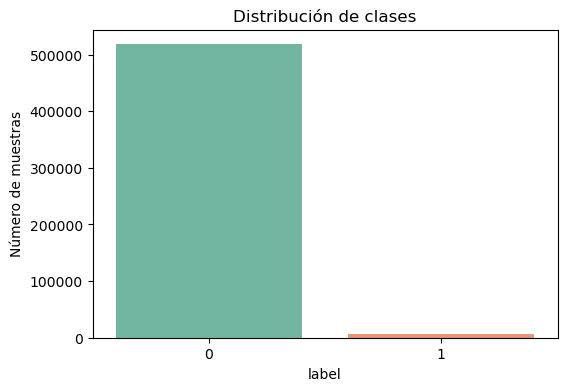

In [6]:
# Gráficamos la distribución
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette="Set2")
plt.title("Distribución de clases")
plt.ylabel("Número de muestras")
plt.show()


Despues de leer los datos y ver la distribución de la clase objetivo, se puede ver un fuerte desbalanceo, dominando la clase no phising por un gran margen. Lo cual, podría ser un problemas para algunas pruebas pero se tratará en el preprocesamiento.

Ahora procedermos a ver  más características de estos datos y comentarlos

In [7]:
# Resumen estadístico de las variables
df.describe()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
count,5.248460e+05,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000,524846.000000
mean,2.762280e+02,123.012167,80.045465,0.895588,0.347767,2.114897,24.694731,0.245301,0.013240
std,3.335457e+03,201.626478,1023.330380,5.603001,1.774209,13.592682,311.312358,0.559320,0.114301
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.700000e+01,38.000000,12.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,1.200000e+02,79.000000,34.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000
75%,2.690000e+02,145.000000,79.000000,0.000000,0.000000,1.000000,22.000000,0.000000,0.000000
max,2.339682e+06,51251.000000,720411.000000,824.000000,524.000000,1150.000000,190104.000000,7.000000,1.000000


In [8]:
# Información general 
df.info()

# Resumen del mínimo, máximo y media de las variables
df.describe().T[['min','max','mean']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524846 entries, 0 to 524845
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   num_words            524846 non-null  int64
 1   num_unique_words     524846 non-null  int64
 2   num_stopwords        524846 non-null  int64
 3   num_links            524846 non-null  int64
 4   num_unique_domains   524846 non-null  int64
 5   num_email_addresses  524846 non-null  int64
 6   num_spelling_errors  524846 non-null  int64
 7   num_urgent_keywords  524846 non-null  int64
 8   label                524846 non-null  int64
dtypes: int64(9)
memory usage: 36.0 MB


,min,max,mean
num_words,0.0,2339682.0,276.228000
num_unique_words,0.0,51251.0,123.012167
num_stopwords,0.0,720411.0,80.045465
num_links,0.0,824.0,0.895588
num_unique_domains,0.0,524.0,0.347767
num_email_addresses,0.0,1150.0,2.114897
num_spelling_errors,0.0,190104.0,24.694731
num_urgent_keywords,0.0,7.0,0.245301
label,0.0,1.0,0.013240


In [9]:
# Comprobamos valores nulos en cada columna
df.isnull().sum()

num_words              0
num_unique_words       0
num_stopwords          0
num_links              0
num_unique_domains     0
num_email_addresses    0
num_spelling_errors    0
num_urgent_keywords    0
label                  0
dtype: int64

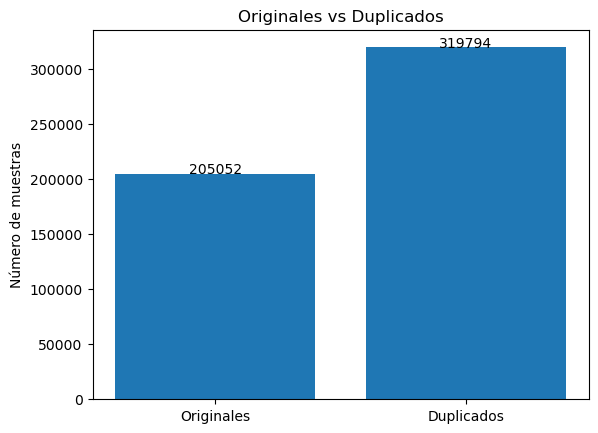

In [10]:
# Comprobamos el número de duplicados
duplicados = df.duplicated().sum()
total = len(df)
sin_duplicados = total - duplicados

# Preparamos los valores para graficar
valores = [sin_duplicados, duplicados]
categorias = ['Originales', 'Duplicados']

# Creamos un gráfico de barras comparando duplicados y originales
plt.bar(categorias, valores)
plt.title("Originales vs Duplicados")
plt.ylabel("Número de muestras")
plt.xlabel("")

# Mostrar valores encima de cada barra
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()



Tras todo esto podemos ver:
- Todas las variables son de tipo **int64**, por lo que no será necesario realizar conversiones adicionales para el entrenamiento.  
- No se detectan **valores nulos** en el dataset.  
- Existe un **alto número de registros duplicados** (más del 50% del total), lo que podría afectar negativamente el rendimiento de varios modelos.  
- También hay muchas variables que tienen medias bajas en comparación con sus máximos, lo que indica una distribución irregular y la posible presencia de **outliers** (ej. `num_spelling_errors` con media ~25 y máximo >190.000). 

# Preprocesamiento 

Tras la exploración inicial de los datos, se procederá a eliminar las entradas duplicadas del dataset, normalización/estandarización de las variables y aplicación de una técnica de oversampling para tratar de equilibrar el número de clases phising.

Número de duplicados después de limpiar: 0
Tamaño nuevo: (205052, 9)


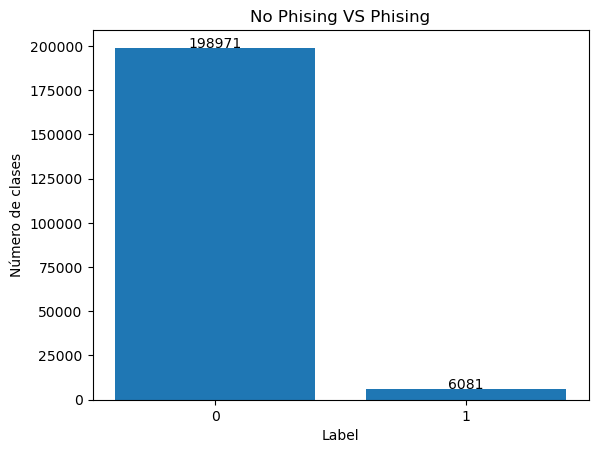

In [12]:
# Eliminación de duplicados
df_clean = df.drop_duplicates()

# Confirmamos que ya no queden duplicados
print("Número de duplicados después de limpiar:", df_clean.duplicated().sum())
print("Tamaño nuevo:", df_clean.shape)


# Visualización de la distribución de clases
categorias = df_clean['label'].value_counts().index.astype(str)   # ['0', '1']
valores = df_clean['label'].value_counts().values                 # cantidades

plt.bar(categorias, valores)
plt.title("No Phising VS Phising")
plt.ylabel("Número de clases")
plt.xlabel("Label")

# Mostrar el valor numérico encima de cada barra
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()

A pesar de haber eliminado más de la mitad de las entradas por duplicados, el dataset resultante aún conserva un volumen considerable (cerca de 200.000 registros).  
Esta cantidad es suficiente para entrenar los modelos, y además se verá incrementada posteriormente mediante la técnica de **oversampling (SMOTE)** para equilibrar las clases.


Ahora veremos la distribución de las variables

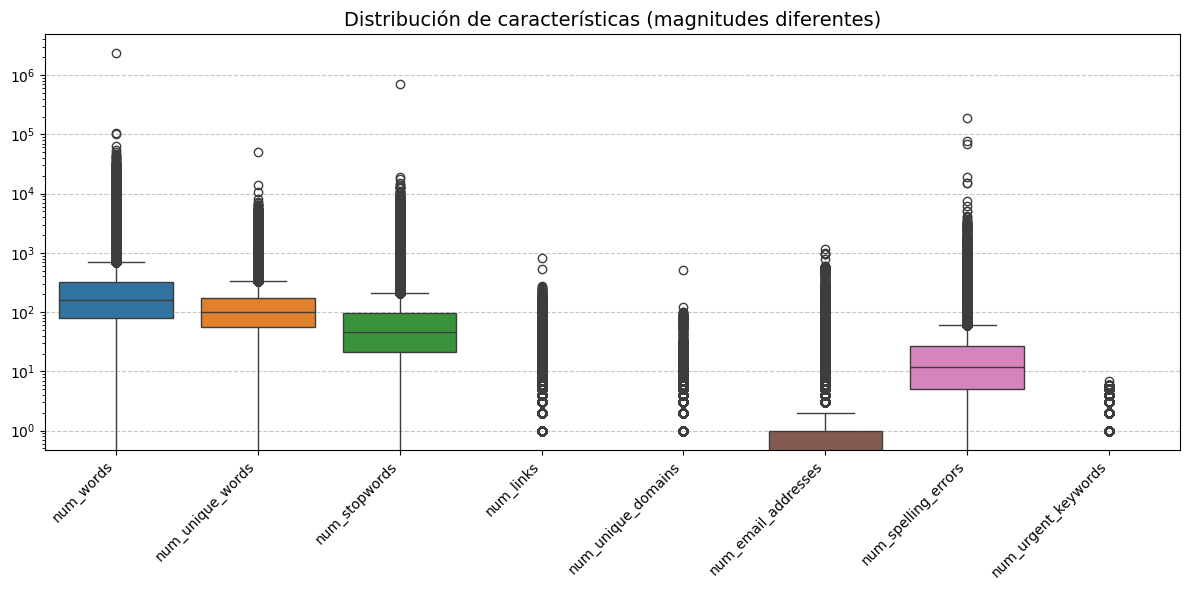

In [13]:
# Seleccionamos todas las columnas excepto la variable objetivo
features = [col for col in df_clean.columns if col != "label"]

# Gráfico de caja (boxplot) para todas las variables
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean[features])

# Ajustes de estilo
plt.title("Distribución de características (magnitudes diferentes)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yscale("log")  # Usamos escala logarítmica para visualizar mejor las diferencias de magnitud
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


El boxplot evidencia las **diferencias de escala** entre las variables.
- Algunas variables, como `num_words`, `num_unique_words`, `num_stopwords`, `num_spelling_errors` presentan valores muy superiores a su media.  
- Otras, como `num_links`, `num_unique_domains` o `num_email_addresses`, tienen valores bastante pequeños en comparación a los anteriores.  
- Se observa además una gran cantidad de **outliers** en la mayoría de las variables, especialmente en `num_spelling_errors` y `num_words`.

Con esta información podemos ver que variables necesitan mayor escalado que otras y se tendrán en cuenta para el escalado.



In [14]:
# Transformación y escalado de variables

# Definimos dos grupos de variables:
#  - features_log: variables con distribuciones más grandes y con valores extremos (colas largas)
#  - features_only_scale: variables con escalas más pequeñas pero que requieren estandarización
features_log = ['num_words','num_unique_words','num_stopwords','num_spelling_errors']
features_only_scale = ['num_links','num_unique_domains','num_email_addresses','num_urgent_keywords']

# Creamos una copia del conjunto de características
X = df_clean[features_log + features_only_scale].copy()

# Aplicamos la transformación logarítmica a las variables de mayor magnitud
for col in features_log:
    X[col] = np.log1p(X[col])

# Aplicamos un escalado estándar (media 0, desviación estándar 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertimos el resultado a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=features_log + features_only_scale)

# Variable objetivo (label)
y = df_clean["label"]




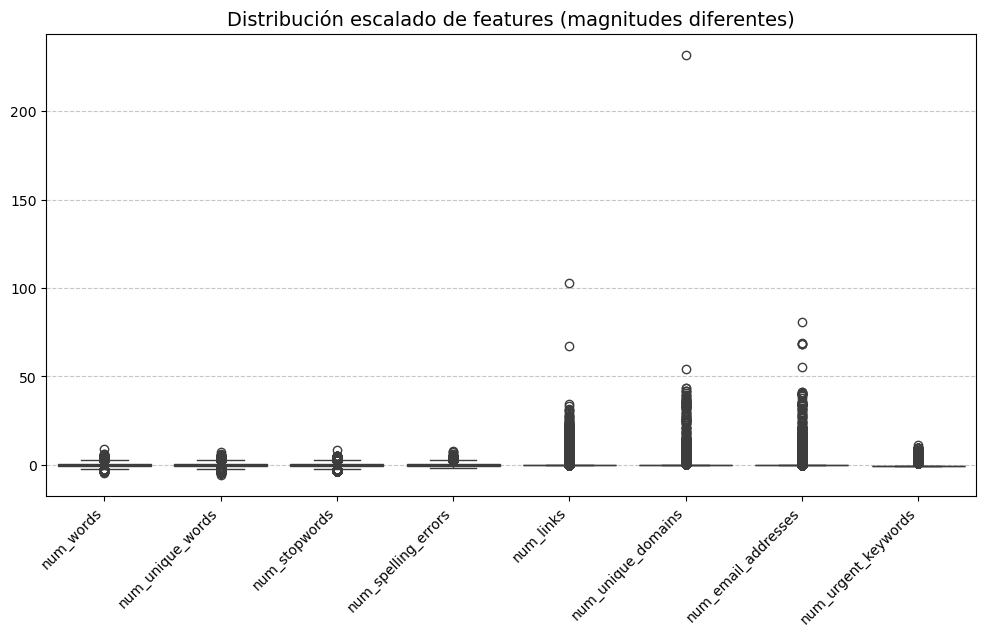

In [15]:
# Boxplot de las variables después del escalado estándar
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_scaled_df)

# Ajustes visuales
plt.title("Distribución escalado de features (magnitudes diferentes)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()


In [16]:
# Resumen estadístico después del escalado
X_scaled_df.describe()

,num_words,num_unique_words,num_stopwords,num_spelling_errors,num_links,num_unique_domains,num_email_addresses,num_urgent_keywords
count,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05,2.050520e+05
mean,1.421955e-15,-6.044579e-16,9.392552e-16,7.698771e-17,-4.833930e-18,-8.602317e-18,-1.898920e-17,-4.792348e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-4.771236e+00,-5.521543e+00,-3.289626e+00,-2.086851e+00,-1.787802e-01,-2.112157e-01,-1.722294e-01,-4.921905e-01
25%,-6.881146e-01,-6.667945e-01,-6.417724e-01,-6.285977e-01,-1.787802e-01,-2.112157e-01,-1.722294e-01,-4.921905e-01
50%,-3.067303e-02,-1.550758e-02,8.493430e-03,6.756711e-04,-1.787802e-01,-2.112157e-01,-1.722294e-01,-4.921905e-01
75%,6.266265e-01,6.259348e-01,6.466527e-01,6.251189e-01,-1.787802e-01,-2.112157e-01,-1.017155e-01,-4.921905e-01
max,8.893930e+00,7.444374e+00,8.264124e+00,7.805967e+00,1.029207e+02,2.320032e+02,8.091878e+01,1.100657e+01


In [17]:
# Resumen del mínimo, máximo y media
X_scaled_df.describe().T[['min','max','mean']]

,min,max,mean
num_words,-4.771236,8.893930,1.421955e-15
num_unique_words,-5.521543,7.444374,-6.044579e-16
num_stopwords,-3.289626,8.264124,9.392552e-16
num_spelling_errors,-2.086851,7.805967,7.698771e-17
num_links,-0.178780,102.920683,-4.833930e-18
num_unique_domains,-0.211216,232.003186,-8.602317e-18
num_email_addresses,-0.172229,80.918775,-1.898920e-17
num_urgent_keywords,-0.492190,11.006572,-4.792348e-17


Después de aplicar la transformación logarítmica y el escalado estándar, las variables presentan medias cercanas a **0** y desviaciones estándar próximas a **1**, lo que significa que el escalado fuen un éxito.

En el boxplot, las distribuciones de las características ya aparecen acorde a esta normalización. Las grandes diferencias de magnitud observadas antes del escalado han desaparecido, aunque todavía se aprecian algunos valores atípicos (outliers), especialmente en las variables `num_links` y `num_unique_domains`. Estos valores extremos no afectan de manera significativa al conjunto de datos.

En conjunto, el siguiente paso sería hacer una partición de los datos y el oversampling.

## Split y  Oversampling

Ahora se procederá a relizar una parttición 80/20 de los datos escalados, junto a la técnica de sobremuestreo **Smote**, con el objetivo de mitigar el desbalanceo entre clases y mejorar la capacidad de generalización de los modelos.

In [21]:
# ====== 1) Split ======
X = X_scaled_df
y = df_clean["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ====== 2) SMOTE solo en TRAIN (30%) ======
print("Train antes:", Counter(y_train))
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Train después:", Counter(y_train_res))

Train antes: Counter({0: 159176, 1: 4865})
Train después: Counter({0: 159176, 1: 47752})


Con este resultado, se puede observar que el sobremuestreo fue logrado, rondado cerca del 30% en el set de entrenamiento.

In [23]:
# Comprobamos la distribución de clases en el conjunto de test
print("Test balance:", Counter(y_test))
print("Proporciones en test:")
display(pd.DataFrame({
    "Cantidad": y_test.value_counts().sort_index(),
    "Proporción (%)": (y_test.value_counts(normalize=True).sort_index() * 100).round(2)
}))


Test balance: Counter({0: 39795, 1: 1216})
Proporciones en test:


,Cantidad,Proporción (%)
label,,
0,39795,97.03
1,1216,2.97


Sin embargo, no lo aplicamos en el conjunto de test. El objetivo es que, durante la fase de evaluación, los modelos se enfrenten a un conjunto de datos con una distribución similar a la de un caso real, posiblemente muy desbalanceado.

Estos serán todos los conjuntos de entrenamiento y test que se usarán en las pruebas de los algoritmos de machine learning

# Entrenamiento de modelos

Antes de entrenar los modelos, se definen las funciones de evaluación y visualización de resultados.

En este caso, se incluye una función auxiliar (_get_proba) que permite obtener probabilidades de predicción tanto en modelos de scikit-learn como en redes neuronales (Keras, TensorFlow).

In [31]:
def _get_proba(model, X):
    """
    Devuelve las probabilidades estimadas de la clase positiva para diferentes tipos de modelos.
   
    Parámetros:
    - model: modelo entrenado 
    - X: datos de entrada

    Retorna:
    - Vector de probabilidades normalizado en el rango [0,1]
    """
    if hasattr(model, "predict_proba"):
        # Modelos sklearn con predict_proba
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        # Modelos sklearn sin predict_proba
        s = model.decision_function(X)
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    # Keras / TF: predict = probas (sigmoid)
    if hasattr(model, "predict"):
        # Modelos Keras / TensorFlow: predict() devuelve directamente las probabilidades
        proba = model.predict(X, verbose=0)
        return proba.ravel() if proba.ndim > 1 else proba
    raise ValueError("El modelo no expone predict_proba/decision_function/predict.")

def evaluar_modelo(model, X_test, y_test, nombre="Modelo", threshold=0.5, train_time=None):
    """
    Evalúa un modelo con las métricas clave:
      - Matriz de confusión
      - Precision, Recall, F1 y PR AUC (Average Precision)
      - Tiempo de entrenamiento 

    Parámetros:
    - model: clasificador entrenado
    - X_test, y_test: datos de test
    - nombre: etiqueta del modelo (para imprimir)
    - threshold: umbral de decisión (por defecto = 0.5)
    - train_time: tiempo de entrenamiento en segundos
    """
    #  Obtenemos probabilidades
    y_proba = _get_proba(model, X_test)
    y_pred  = (y_proba >= threshold).astype(int)

    print(f"=== Evaluación de {nombre} (threshold={threshold}) ===")
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

    # Cálculo de métricas 
    f1_pos  = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_pos = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    pr_auc  = average_precision_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    # Mostrar métricas en consola
    print(f"Precision global: {acc:.4f}")
    print(f"Precision (clase 1): {precision:.4f}")
    print(f"Recall    (clase 1): {rec_pos:.4f}")
    print(f"F1        (clase 1): {f1_pos:.4f}")
    print(f"PR AUC (Average Precision): {pr_auc:.4f}")
    
    # Mostrar tiempo de entrenamiento
    if train_time is not None:
        print(f"Tiempo de entrenamiento: {train_time:.4f} segundos \n")
    else:
        print(f"Tiempo de entrenamiento: no disponible\n")

def graficar_modelo(model, X_test, y_test, nombre="Modelo", threshold=0.5, train_time=None):
    """
    Genera tres gráficas clave para la evaluación del modelo:
      1. Matriz de confusión
      2. Curva Precision–Recall (con PR AUC)
      3. Gráfico de barras con Precision, Recall, F1 y Accuracy en el umbral indicado
    """
    #  Obtenemos probabilidades
    y_proba = _get_proba(model, X_test)
    y_pred  = (y_proba >= threshold).astype(int)

    # Figura principal
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2], wspace=0.25, hspace=0.30)

    # 1) Matriz de confusión
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax1)
    ax1.set_title(f"Matriz de confusión — {nombre}")
    ax1.set_xlabel("Predicción"); ax1.set_ylabel("Real")

    # 2) Curva Precision–Recall
    ax2 = fig.add_subplot(gs[0, 1])
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    ax2.plot(rec, prec, linewidth=2, label=f"PR AUC = {ap:.3f}")
    ax2.set_title(f"Curva Precision–Recall — {nombre}")
    ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision")
    ax2.legend(loc="lower left")

    # 3) Gráfico de barras (métricas)
    ax3 = fig.add_subplot(gs[1, :])
    p1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    r1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    acc= accuracy_score(y_test, y_pred)
    ax3.bar(["Precision_1","Recall_1","F1_1","Accuracy"], [p1, r1, f1, acc])
    ax3.set_ylim(0, 1)
    ax3.set_title(f"Métricas principales (threshold = {threshold}) — {nombre}")

    plt.tight_layout()
    plt.show()

    # Mostrar métricas numéricas
    print(f"Threshold = {threshold}")
    print(f"Precision (clase 1): {p1:.4f}")
    print(f"Recall    (clase 1): {r1:.4f}")
    print(f"F1        (clase 1): {f1:.4f}")
    print(f"PR AUC (Average Precision): {ap:.4f}")
    print(f"Precision global: {acc:.4f}")
    
    # Mostrar tiempo de entrenamiento
    if train_time is not None:
        print(f"Tiempo de entrenamiento: {train_time:.4f} segundos \n")
    else:
        print(f"Tiempo de entrenamiento: no disponible\n")




## Multilayer Perceptron (MLP)

### Experimento 1

En esta primera prueba se implementron dos capas densas de **128 y 64 neuornas**, respectivamente, utilizando las función de activación **ReLU** para capturar relaciones no lineales de los datos. También utilizamons una capa de **Batch Normalization**, para mejorar la estabilidad y acelerar la convergencia. Y en conjunto a la aplicación del **Droput de 0.3** en cada capa como mecanismo de regularización del sobreajuste.

El modelo fue compilado con el **optimizador Adam** y tasa de aprendizaje de **1e-3**, utilizando la función de pérdida **Binary Crossentropy**.

Finalmente, se implementó un esquema de **early stopping**, monitoreando la métrica de validación **val_pr_auc** con una paciencia de **5 épocas**, parando cuando no encuentre valores que mejoren los resultados. El modelo se entrenó con un máximo de **100 épocas** con un **batch size** de **1024**, reservando un 10 % de los datos de entrenamiento para validación interna.

In [39]:
# Reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

input_dim = X_train_res.shape[1]  # número de features (8 en tu dataset)

# Modelo MLP (Baseline)
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # salida binaria en [0,1]
])

# Compilación
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),  
    metrics=[
        
        keras.metrics.AUC(curve="PR", name="pr_auc"), 
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ],
)


# Callbacks (Early Stopping) 
early = keras.callbacks.EarlyStopping(
    monitor="val_pr_auc",   # métrica principal en validación
    mode="max",
    patience=5,
    restore_best_weights=True
)

# Entrenamiento
start = time.time()

history = model.fit(
    X_train_res, y_train_res,
    validation_split=0.1,    # reserva 10% del train_res para validar 
    epochs=100,
    batch_size=1024,
    callbacks=[early],
    verbose=1                # Mostrar entrenamiento
)
train_time_MLP1 = time.time() - start

Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.4069 - pr_auc: 0.2285 - precision: 0.4224 - recall: 0.0338 - roc_auc: 0.6440 - val_loss: 1.7028 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.0696 - val_roc_auc: 0.0000e+00
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.3542 - pr_auc: 0.3870 - precision: 0.6545 - recall: 0.1091 - roc_auc: 0.7626 - val_loss: 1.7712 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.0857 - val_roc_auc: 0.0000e+00
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3450 - pr_auc: 0.4140 - precision: 0.6464 - recall: 0.1404 - roc_auc: 0.7810 - val_loss: 1.7876 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.0913 - val_roc_auc: 0.0000e+00
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3399 - pr_auc: 0.4311 - precision: 0.6519 - recall: 0.1609 - roc_auc: 0.7903 - val_loss: 1.7616 - val_pr_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.0987 - val_roc_auc: 0.0

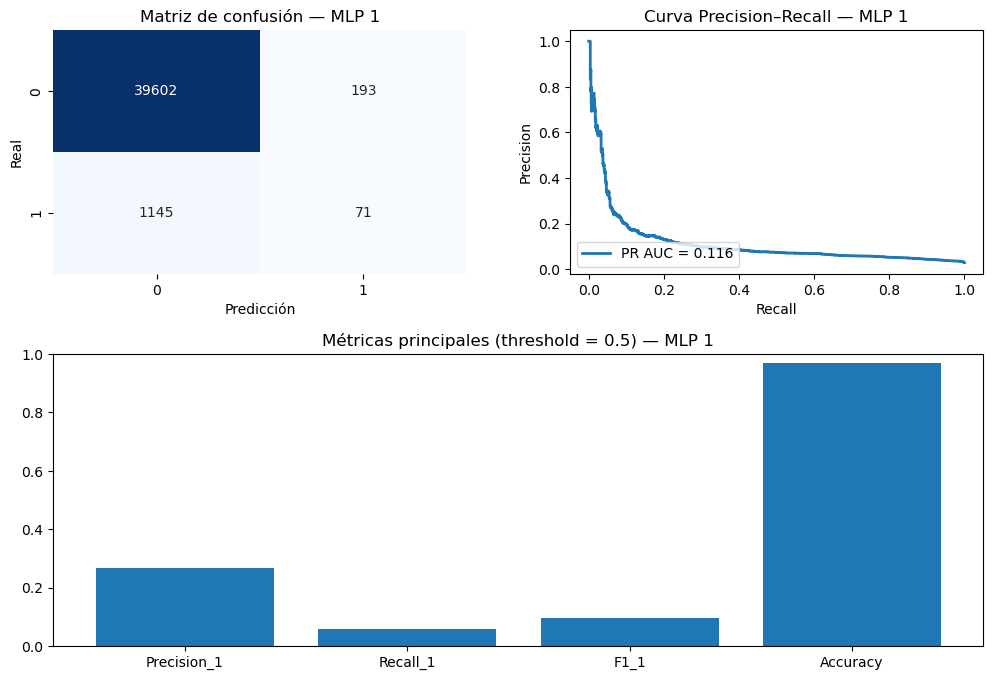

Threshold = 0.5
Precision (clase 1): 0.2689
Recall    (clase 1): 0.0584
F1        (clase 1): 0.0959
PR AUC (Average Precision): 0.1155
Precision global: 0.9674
Tiempo de entrenamiento: 21.3988 segundos 



In [40]:
# Evaluamos en test
graficar_modelo(model, X_test, y_test, nombre="MLP 1", threshold=0.5, train_time=train_time_MLP1)


La **precisón global** de este modelo es muy buena, alcanzado valores cercanos al **97%**. Pero es un valor engañoso debido al pobre rendimiento del resto de métricas, un **PR AUC** de **0.116** y **F1-Score** de **0.096**, este último debido al bajo recall obtenido.

El posible problema de este experimento, puede debeerse a la validación que se hizo con un split dentro de los datos balanceados de SMOTE, lo que hizo que la métrica de validación (PR AUC) apareciera siempre perfecta (1.0) desde el inicio en los logs, haciendo detener el entrenamiento de antemano.

### Experimento 2

Para evitar la validación "inflada", en este experimento de separá primero un conjunto de validación real sin SMOTE a partir del train original (estratificado 90/10). Después, se aplicó la técnica solo sobre el sub-train, preservando la distribución real en validación.

El modelo se amplió a tres capas densas de **256, 128 y 64** neuronas, se redujo el dropout a **0.2**, se entrenó con **Adam** con una tasa de aprendizaje de **3e-4**, EarlyStopping con paciencia **8**, la introducción **ReduceLROnPlateau**, el cual reduce automáticamente la tasa de aprendizaje, y **batch_size** de **512**. 

In [44]:
# División en train y validación real (sin SMOTE)
# Se crea una pequeña partición (10%) de validación a partir del conjunto de entrenamiento original.
# Esto permite evaluar el modelo en una distribución real, sin datos sintéticos.
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


# Aplicar SMOTE solo al sub-train
print("Train antes:", Counter(y_tr))
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)
print("Train después:", Counter(y_tr_res))

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)
input_dim = X_tr_res.shape[1]

# Modelo MLP (256-128-64)
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Compilación
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento
start = time.time()

history = model.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     # <- validación real
    epochs=100, batch_size=512,
    callbacks=[early, rlrop],
    verbose=1
)

train_time_MLP2 = time.time() - start

Train antes: Counter({0: 143258, 1: 4378})
Train después: Counter({0: 143258, 1: 42977})
Epoch 1/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7831 - loss: 0.4835 - pr_auc: 0.4386 - precision: 0.6387 - recall: 0.1383 - roc_auc: 0.7143 - val_accuracy: 0.9551 - val_loss: 0.2123 - val_pr_auc: 0.1659 - val_precision: 0.2323 - val_recall: 0.2218 - val_roc_auc: 0.7973 - learning_rate: 3.0000e-04
Epoch 2/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8002 - loss: 0.4320 - pr_auc: 0.5541 - precision: 0.6472 - recall: 0.2954 - roc_auc: 0.7958 - val_accuracy: 0.9570 - val_loss: 0.1958 - val_pr_auc: 0.1929 - val_precision: 0.2545 - val_recall: 0.2320 - val_roc_auc: 0.8193 - learning_rate: 3.0000e-04
Epoch 3/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8043 - loss: 0.4212 - pr_auc: 0.5765 - precision: 0.6565 - recall: 0.3192 - roc_auc: 0.8096 - val_accuracy: 0.9567 - val_loss: 0.1942 - val_pr_auc: 0.2100 - val_precision: 0.2633 - val_recall: 0.2546 - val_

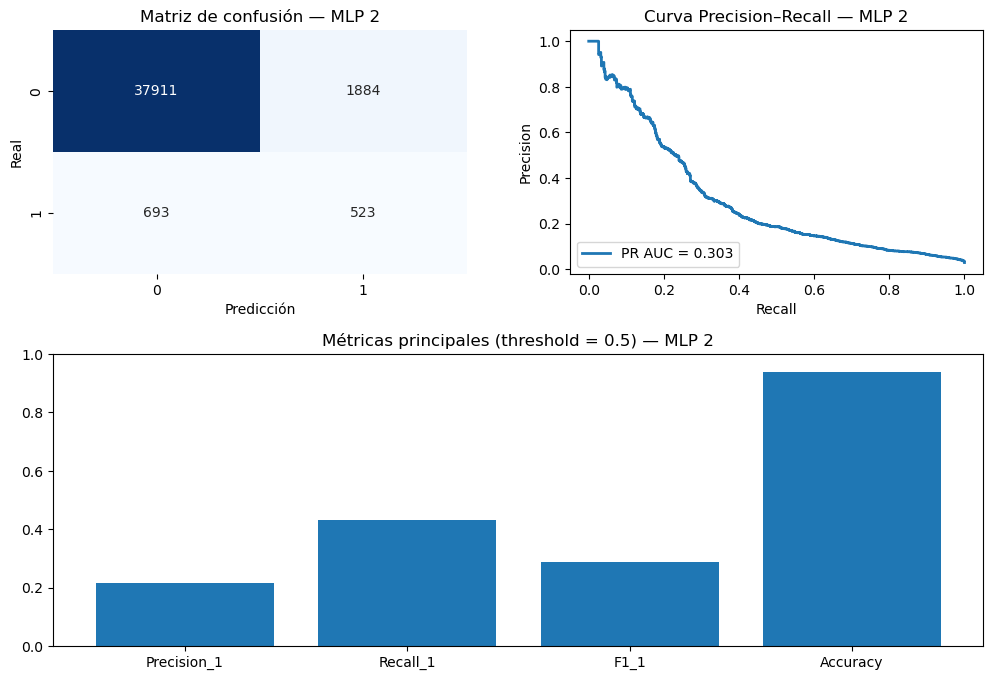

Threshold = 0.5
Precision (clase 1): 0.2173
Recall    (clase 1): 0.4301
F1        (clase 1): 0.2887
PR AUC (Average Precision): 0.3026
Precision global: 0.9372
Tiempo de entrenamiento: 535.3952 segundos 



In [45]:
# Evaluamos en test
graficar_modelo(model, X_test, y_test, nombre="MLP 2", threshold=0.5, train_time=train_time_MLP2)

Gracias a estos cambios el modelo no se paró prematuramente y pudo entrenar completamente. Alcanzando valores bastantes buenos comparando a los algortimos de Machine Learning, con un **PR AU** de **0.303** , un **F1** de **0.289** y un mejor equilibrio de recall y precisión. Sin embargo, el **tiempo** de entrenamiento ronda cerca de los **9 minutos**, bastante más del algortimo promedio en ML.

Esto demuestra que esta arquitectura se desempeña mejor sin una gran presencia de sobremuestreo en el entrenamiento, añadido a los demás cambios.

### Experimento 3

En esta configuración se probó con arquitectura más profunda y regularizada, ampliando a cuatro capas ocultas de **512, 256, 128 y 64 neuronas**, empleando la función de activación **Swish**, e cual ofrece una transición más suave que ReLU y utilizandon. Además, en cada capa se aplico un **Batch Normalization** y se reforzó la regularización mediante la inclusión de penalización **L2 (1e-4)** 

Se optimizó con **AdamW**, una variante que incorpora **weight decay**, junto con clipping de gradiente (**clipnorm=1.0**) para evitar actualizaciones inestables. Y el **sobremuestreo** se modificó, aumentado hasta **40%** el número de muestras sintéticas sobre el conjunto de entrenamiento.  

Early Stopping fue modificado con una mayor **paciencia**, **10** y ReduceLROnPlateau con paciencia **4**, permitiendo reducciones dinámicas de la tasa de aprendizaje. Y el entrenamiento fue prolongado con **150 épocas**.

In [49]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, k_neighbors=7, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features


# Modelo MLP (512-256-128-64)
model3 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(512, activation="swish", kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation="swish", kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation="swish", kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation="swish", kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])


# Optimizador AdamW con weight decay y clipping para mayor estabilidad
optimizer = keras.optimizers.AdamW(
    learning_rate=3e-4, weight_decay=1e-4, clipnorm=1.0
)

# Compilación
model3.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=10, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=4, min_lr=1e-5)

# Entrenamiento
start = time.time()

history3 = model3.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),  
    epochs=150,
    batch_size=512,
    callbacks=[early, rlrop],
    verbose=1
)

train_time_MLP3 = time.time() - start

Epoch 1/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.7280 - loss: 0.6133 - pr_auc: 0.5683 - precision: 0.5222 - recall: 0.5634 - roc_auc: 0.7661 - val_accuracy: 0.9706 - val_loss: 0.2473 - val_pr_auc: 0.1468 - val_precision: 0.8333 - val_recall: 0.0103 - val_roc_auc: 0.7695 - learning_rate: 3.0000e-04
Epoch 2/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7752 - loss: 0.5191 - pr_auc: 0.6414 - precision: 0.6395 - recall: 0.4886 - roc_auc: 0.8193 - val_accuracy: 0.9665 - val_loss: 0.2264 - val_pr_auc: 0.2177 - val_precision: 0.3648 - val_recall: 0.1745 - val_roc_auc: 0.8296 - learning_rate: 3.0000e-04
Epoch 3/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.7820 - loss: 0.4959 - pr_auc: 0.6636 - precision: 0.6590 - recall: 0.4911 - roc_auc: 0.8336 - val_accuracy: 0.9673 - val_loss: 0.2063 - val_pr_auc: 0.2159 - val_precision: 0.3816 - val_recall: 0.1622 - val_roc_auc: 0.8244 - learning_rate: 3.0000e-04
Epoch 4/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 19

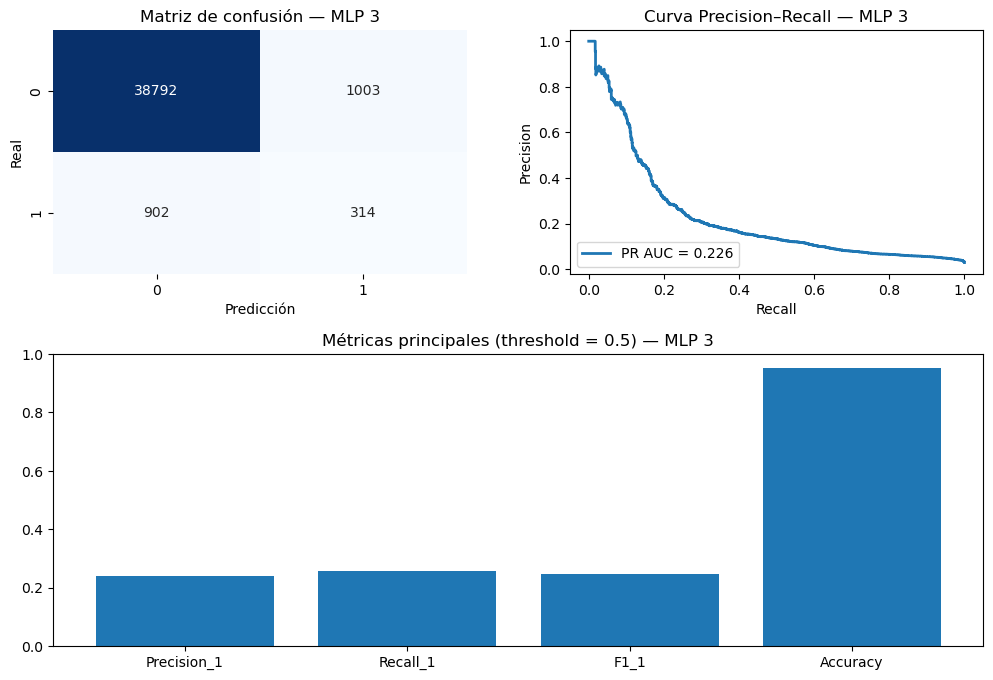

Threshold = 0.5
Precision (clase 1): 0.2384
Recall    (clase 1): 0.2582
F1        (clase 1): 0.2479
PR AUC (Average Precision): 0.2256
Precision global: 0.9535
Tiempo de entrenamiento: 594.2309 segundos 



In [50]:
# Evaluamos en test
graficar_modelo(model3, X_test, y_test, nombre="MLP 3", threshold=0.5, train_time=train_time_MLP3)

El modelo alcanzó un **PR AUC de 0.226** y un **F1 de 0.248**, con un balance moderado entre precisión  y recall. A pesar de la arquitectura más profunda y las técnicas adicionales de regularización, el rendimiento fue inferior al anterior, lo que sugiere que el incremento de complejidad no aportó mejoras significativas y podría haber provocado cierta dificultad de generalización.

EL cual también influyó en el **tiempo** de entrenamiento, que fue cercano a **10 minutos**.

### Experimento 4

En esta prueba se redujo la complejidad del modelo, pasando de cuatro a tres **capas** densas de **256, 128, 64 neuronas**, solo se aplica **Batch Normalization** en la primera capa,  y eliminando la regularización **L2** y el optimizador **AdamW** con weight decay utilizados anteriormente.

Se conservaron la activación Swish, el Dropout (0.2), las mismas estrategias de entrenamiento y validación, y tanto el EarlyStopping como ReduceLROnPlateau se matuvieron iguales al del experimento 2.

Esto con el  objetivo de comprobar si una red más ligera, con menos restricciones, podía mantener el rendimiento si demasiado coste computacional.


In [51]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, k_neighbors=7, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)


# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64)
model4 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="swish"),  
    layers.Dropout(0.2),
    layers.Dense(128, activation="swish"),  
    layers.Dropout(0.2),
    layers.Dense(64,  activation="swish"),  
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Compilación
model4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),   
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = keras.callbacks.EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento
start = time.time()

history4 = model4.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),   
    epochs=100, batch_size=512,       
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP4 = time.time() - start


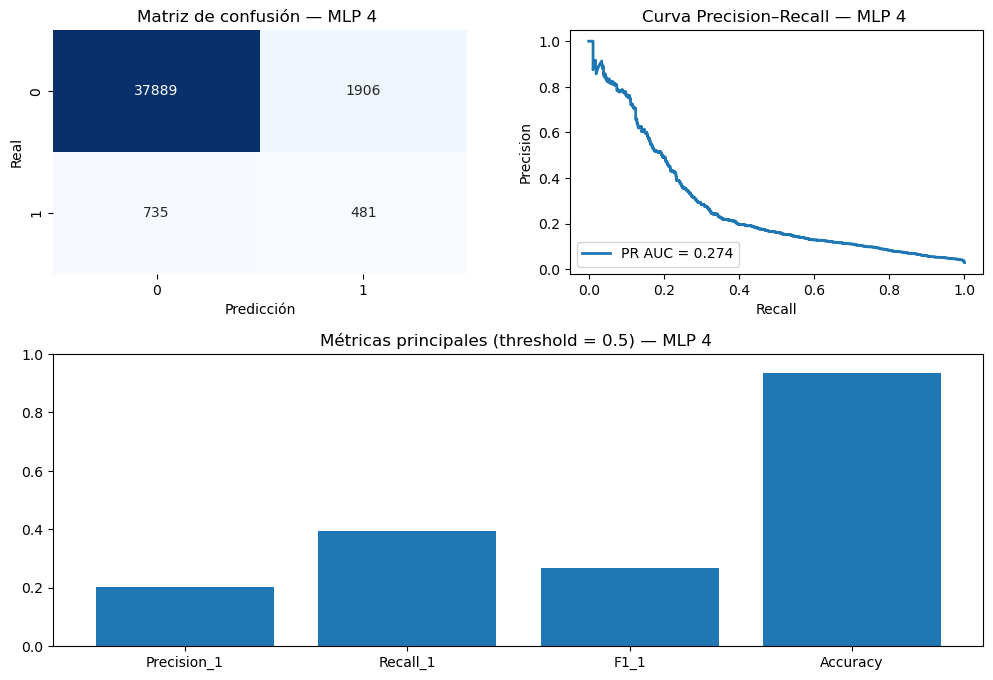

Threshold = 0.5
Precision (clase 1): 0.2015
Recall    (clase 1): 0.3956
F1        (clase 1): 0.2670
PR AUC (Average Precision): 0.2737
Precision global: 0.9356
Tiempo de entrenamiento: 485.3717 segundos 



In [52]:
# Evaluamos en test
graficar_modelo(model4, X_test, y_test, nombre="MLP 4 ", threshold=0.5, train_time=train_time_MLP4)

Se obtuvo un **PR AUC de 0.274** y un **F1 de 0.267**, mostrando una ligera mejora respecto al modelo más complejo en la relación entre recall y precisión , pese a tener menos capas y sin regularización L2.

Estos resultados indican que la reducción de profundidad permitió mantener un rendimiento competitivo e incluso más equilibrado, con un **tiempo** de entrenamiento menor, cerca de los **8 minutos**.

### Experimento 5

En este experimento reducimos el nivel de **sobremuestreo** de 40% a **30%**, analizando si tiene algun efecto positivo. Después se cambió la función de activación a **ReLU** para favorecer la convergencia. Y por último, se redujo el **batch_size** a **256** buscando un aprendizaje más fino con actualizaciones más frecuentes.

También cabe recalcar que a partir de ahora, se usará **verbose=0** en el entrenamiento para no mostrar las epochs en tiempo real con el fin de mejorar la visualización y limpieza de los experimentos.


In [53]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64)
model5 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Compilación
model5.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento
start = time.time()

history5 = model5.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, batch_size=256,   
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP5 = time.time() - start

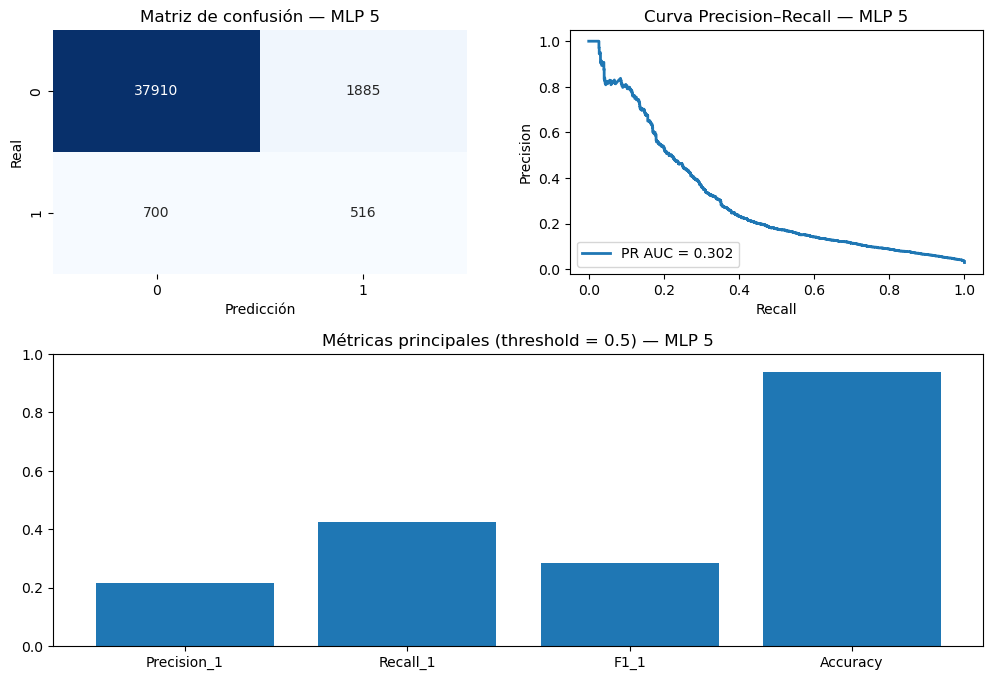

Threshold = 0.5
Precision (clase 1): 0.2149
Recall    (clase 1): 0.4243
F1        (clase 1): 0.2853
PR AUC (Average Precision): 0.3022
Precision global: 0.9370
Tiempo de entrenamiento: 261.2863 segundos 



In [54]:
# Evaluamos en test
graficar_modelo(model5, X_test, y_test, nombre="MLP 5", threshold=0.5, train_time=train_time_MLP5)

Se consiguió un **PR AUC de 0.3022** y un **F1 de 0.285**, resultados similares a los mejores obtenidos hasta ahora. Pero en este caso, con un **tiempo** de entrenamiento bastante menor, rondando los **4 minutos**.

Confirmando que esta combinación tuvos unos efectos bastantes positivos, pero se pueden mejorar.

### Experimento 6

Solo se realizaron dos cambios esta vez, se aumentó otra vez el **sobremuestro** al **40%**, para comprobar otra vez sus efectos, y se incrementó el **batch_size** a 512 buscando mayor estabilidad.

In [56]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, random_state=42) 
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64)
model6 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Compilación
model6.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento
start = time.time()

history6 = model6.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, batch_size=512,    
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP6 = time.time() - start

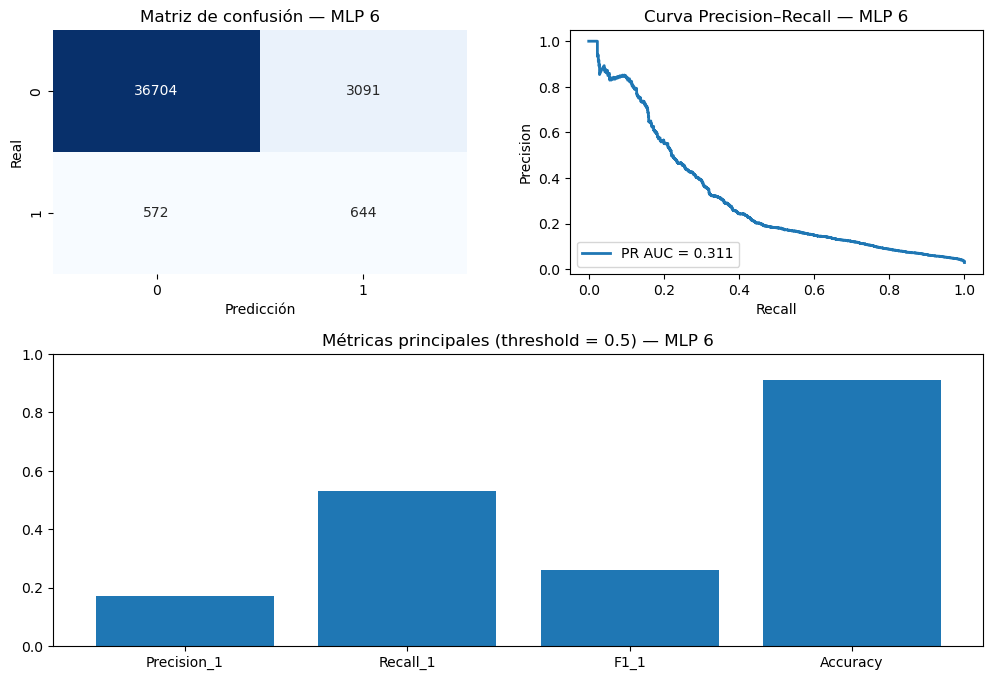

Threshold = 0.5
Precision (clase 1): 0.1724
Recall    (clase 1): 0.5296
F1        (clase 1): 0.2601
PR AUC (Average Precision): 0.3107
Precision global: 0.9107
Tiempo de entrenamiento: 315.4811 segundos 



In [57]:
# Evaluamos en test
graficar_modelo(model6, X_test, y_test, nombre="MLP 6", threshold=0.5, train_time=train_time_MLP6)

Aumentó el **PR AUC a 0.311** pero a costa de de bajar un poco el **F1 a 0.260**, esto debido a que la precision disminuyó en gran medida. El **tiempo** de entrenamiento se mantuvo moderado, cerca de **5 minutos**.

La subida del sobremuestreo permitió una mejor detección de la clase minoritaria, pero incrementó el número de falsos positivo.

### Experimento 7

Ahora volvemos a usar **SMOTE con 0.3** y se sustituye Adam por **AdamW** con **weight decay(1e-4)**, manteniendo el resto del modelo igual. Esto para comprobar los resultados obtenidos con esta versión de Adam.

In [59]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64)
model7 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Optimizador AdamW con weight decay 
optimizer = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)  

# Compilación
model7.compile(
    optimizer=optimizer,   
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento
start = time.time()

history7 = model7.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, batch_size=512,   
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP7 = time.time() - start

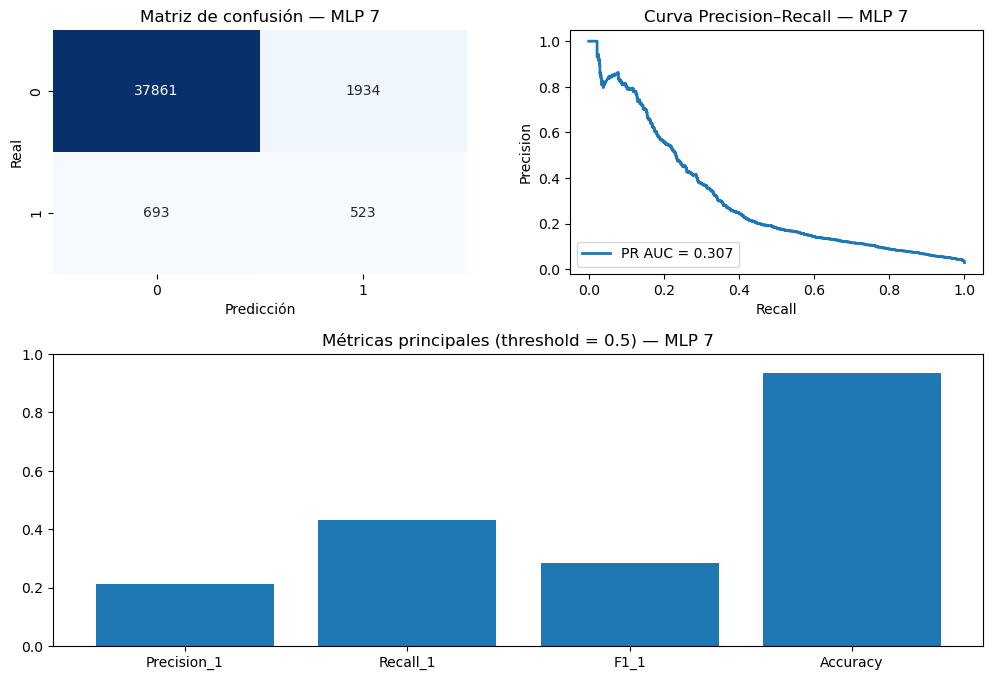

Threshold = 0.5
Precision (clase 1): 0.2129
Recall    (clase 1): 0.4301
F1        (clase 1): 0.2848
PR AUC (Average Precision): 0.3072
Precision global: 0.9359
Tiempo de entrenamiento: 276.7558 segundos 



In [60]:
# Evaluamos en test
graficar_modelo(model7, X_test, y_test, nombre="MLP 7", threshold=0.5, train_time=train_time_MLP7)

Un **PR AUC de 0.307** y **F1 de 0.285** son unos buenos resultados, y a pesar que disminuya un poco la capacidad discriminativa, tanto la precisión y el recall son mejores y más o menos equilibrados.

AdamW con weight decay ha logrado  por ahora métricas estables y un mejora en la optimización

### Experimento 8

En este caso se introduce **label smoothing** en la pérdida (BinaryCrossentropy) con un valor **0.03**, esto con el objetivo de reducir la sobreconfianza de las predicciones y mejorar la calibración del modelo, buscando un equilibrio más estable entre precisión y recall.

In [61]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64)
model8 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Compilación
model8.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.03), 
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento
start = time.time()

history8 = model8.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),  
    epochs=100, batch_size=512,    
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP8 = time.time() - start

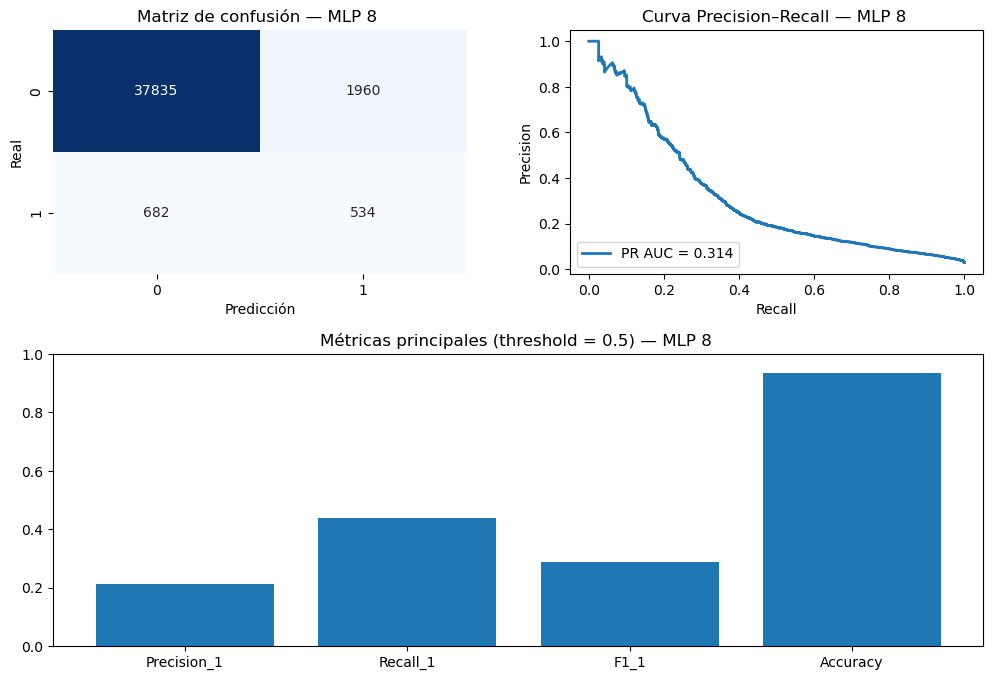

Threshold = 0.5
Precision (clase 1): 0.2141
Recall    (clase 1): 0.4391
F1        (clase 1): 0.2879
PR AUC (Average Precision): 0.3139
Precision global: 0.9356
Tiempo de entrenamiento: 432.2306 segundos 



In [62]:
# Evaluamos en test
graficar_modelo(model8, X_test, y_test, nombre="MLP 8 ", threshold=0.5, train_time=train_time_MLP8)

Label smoothing tuvo como efecto mejorar las métricas del antiguo experimento aunque sea en pequeña medida, con **PR AUC de 0.314** y F1 de **0.288**. No obstante, aumentó el **tiempo** de entrenamiento acercandose alos **7 minutos**.


### Experimento 9

A continuación, probaremos a introducir una nueva **capa** densa de **32 neuronas** con función de activación **ReLU**,  y **DropOut 0.2** al final, quitando el label smoothing.

In [63]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64)
model9 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32,  activation="relu"),   # <- capa nueva
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Compilación
model9.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-5)

# Entrenamiento
start = time.time()

history9 = model9.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),  
    epochs=100, batch_size=512,
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP9 = time.time() - start

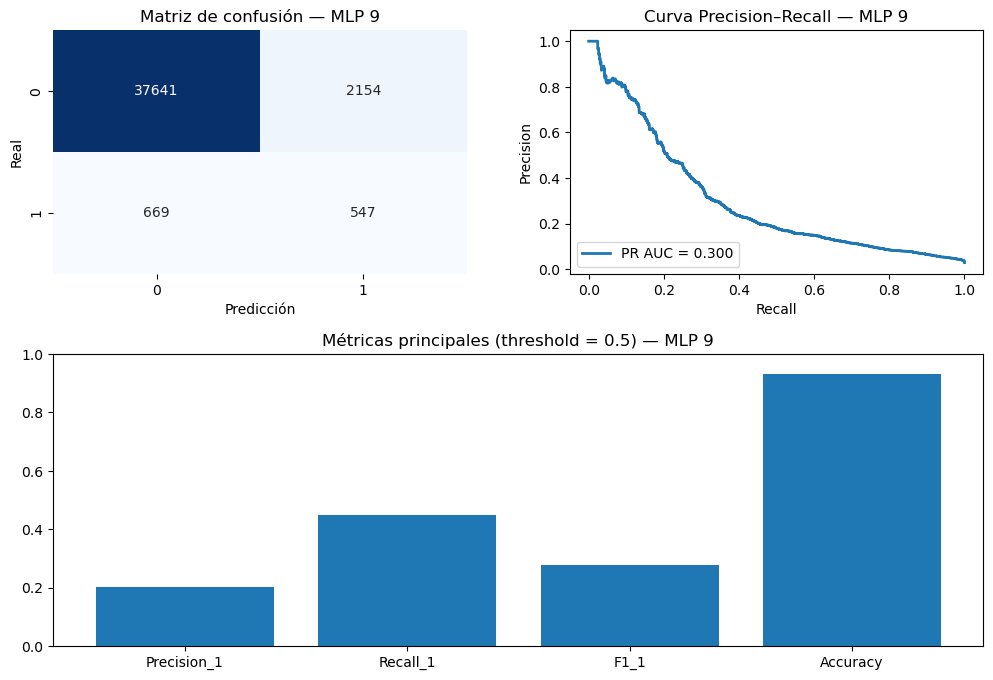

Threshold = 0.5
Precision (clase 1): 0.2025
Recall    (clase 1): 0.4498
F1        (clase 1): 0.2793
PR AUC (Average Precision): 0.2999
Precision global: 0.9312
Tiempo de entrenamiento: 271.3272 segundos 



In [64]:
# Evaluamos en test
graficar_modelo(model9, X_test, y_test, nombre="MLP 9", threshold=0.5, train_time=train_time_MLP9)

El rendimiento general fue inferior a las versiones previas, **PR AUC de 0.300** y **F1 de 0.279**. En cambio el **tiempo** de entrenamiento rondo los **4 minutos**, mateniéndose estable.

Sin embargo, por ahora no ha dado muy buenos resultados comparados al resto esta nueva capa de 32 neuronas

### Experimento 10

Volvemos a la estructura de capas anterior y probamos a cambiar el ritmo de paradas.

**EarlyStopping** con paciencia subida a **12**, para evitar paradas prematuras y permitir más epocas. Y **ReduceLROnPlateau** con mayor paciencia de **5**, para dar más margen antes de reducir la tasa de aprendizaje y favorecer ajustes más estables.



In [65]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64)
model10 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Compilación
model10.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=12, restore_best_weights=True) 
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5) 

# Entrenamiento
start = time.time()

history10 = model10.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),    
    epochs=100, batch_size=512,
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP10 = time.time() - start

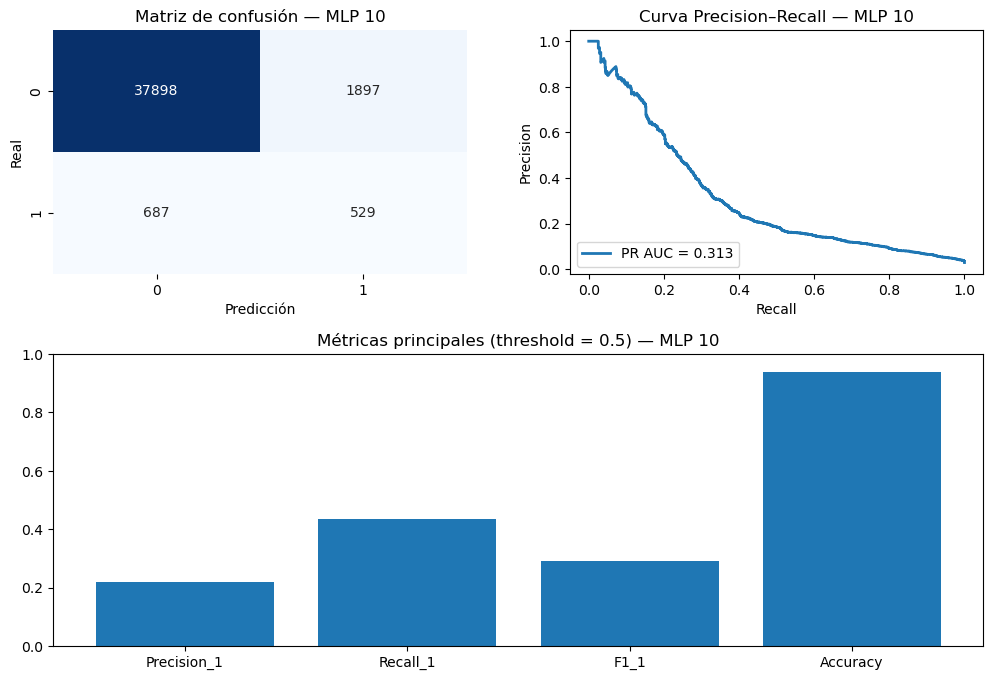

Threshold = 0.5
Precision (clase 1): 0.2181
Recall    (clase 1): 0.4350
F1        (clase 1): 0.2905
PR AUC (Average Precision): 0.3131
Precision global: 0.9370
Tiempo de entrenamiento: 366.8679 segundos 



In [66]:
# Evaluamos en test
graficar_modelo(model10, X_test, y_test, nombre="MLP 10", threshold=0.5, train_time=train_time_MLP10)

Obtenemos un resultado parecido al mejor experimento hecho hasta ahora, solo que suben un poco algunas métricas como **F1 con 0.290** y otras bajan un poco como **PR AUC con 0.313**, aunque es mínimo. Por otro lado, es más rápido con un **tiempo** de entrenamiento cerca a los **6 minutos** 

Este cambio permitió una mejor convergencia y resultados más estables.

### Experimento 11

En esta configuración se implementó una combinación de los cmabios hechos basados en pruebas anteiores. 

Se aumentó el nivel de **sobremuestreo a 40 %** para potenciar la detección de la clase minoritaria, y se empleó una arquitectura algo más profunda **(256–128–64–32)** con una capa adicional de 32 neuronas para mejorar la capacidad de representación.
Además, se incorporó regularización explícita mediante **AdamW** con **weight decay (1e-4)** y **label smoothing (0.03)**, con el fin de reducir la sobreconfianza y favorecer una mejor generalización

In [67]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, random_state=42)  
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64-32)
model11 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32,  activation="relu"),  
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Optimizador AdamW con weight decay
optimizer = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4) 

# Compilación
model11.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.03), 
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=12, restore_best_weights=True) 
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5) 

# Entrenamiento
start = time.time()

history11 = model11.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, batch_size=512,
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP11 = time.time() - start

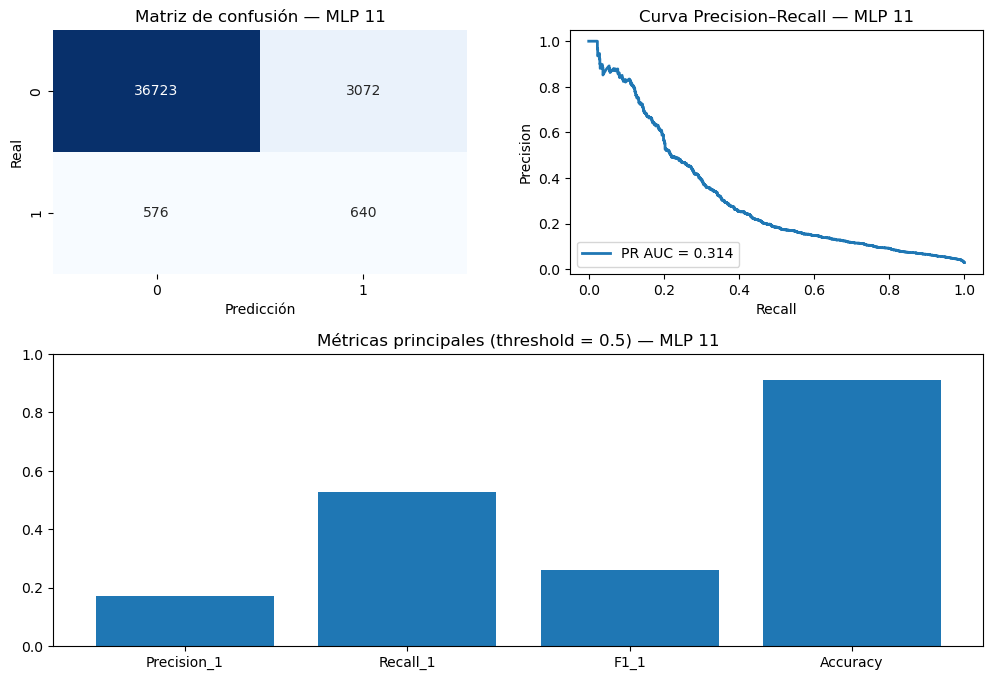

Threshold = 0.5
Precision (clase 1): 0.1724
Recall    (clase 1): 0.5263
F1        (clase 1): 0.2597
PR AUC (Average Precision): 0.3142
Precision global: 0.9110
Tiempo de entrenamiento: 338.8336 segundos 



In [68]:
# Evaluamos en test
graficar_modelo(model11, X_test, y_test, nombre="MLP 11", threshold=0.5, train_time=train_time_MLP11)

Se obtuvo un rendimiento decente en general, **PR AUC de 0.314** y **F1 de 0.260**, destacando un recall alto a costas de baja precisión, y en un **tiempo** promedio de **5 minutos**.

Esta combinación permitió una buena generalización e incremento ciertas métricas, pero se esperaba algo más de una set de parámetros como este.

### Experimento 12

Partimos del mismo conjunto de parámetros que el anterior, pero ahora se incrementó la capacidad del modelo aumentando el número de neuronas en las capas, teniendo ahora 4 con **512, 256, 128 y 32 neuronas**.

In [109]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, random_state=42)  
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (512-256-128-32)
model12 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32,  activation="relu"),  
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Optimizador AdamW con weight decay
optimizer = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)  

# Compilación
model12.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.03), 
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=12, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5)

# Entrenamiento
start = time.time()

history12 = model12.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, batch_size=512,
    callbacks=[early, rlrop],
    verbose=0
)
train_time_MLP12 = time.time() - start



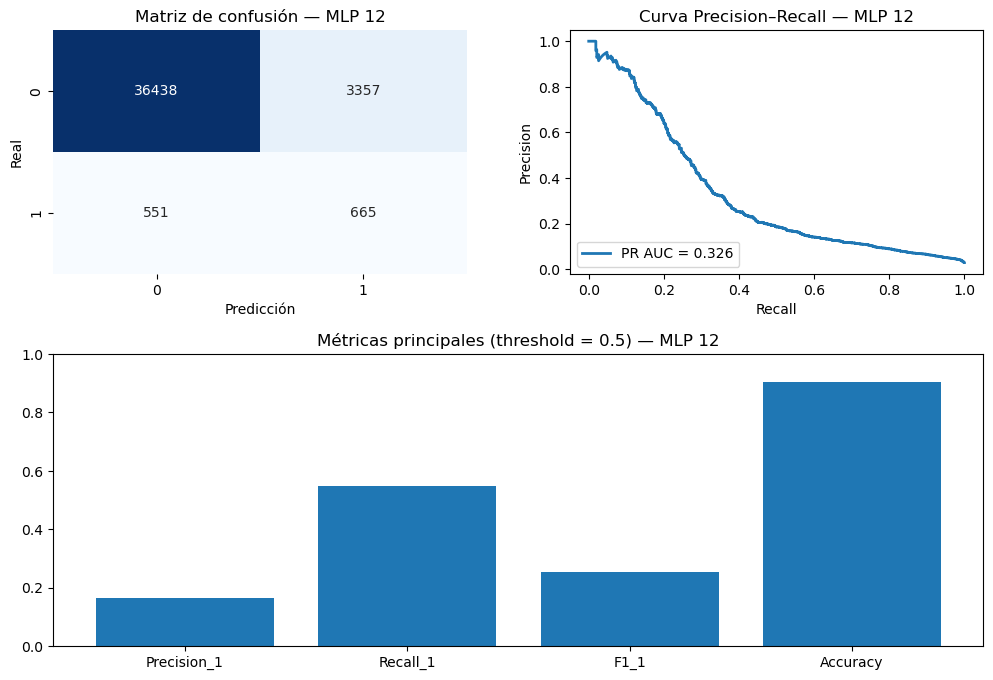

Threshold = 0.5
Precision (clase 1): 0.1653
Recall    (clase 1): 0.5469
F1        (clase 1): 0.2539
PR AUC (Average Precision): 0.3260
Precision global: 0.9047
Tiempo de entrenamiento: 709.7694 segundos 



In [108]:
# Evaluamos en test:
graficar_modelo(model12, X_test, y_test, nombre="MLP 12", threshold=0.5, train_time=train_time_MLP12)

Se consiguió mejorar el **PR AUC cn 0.326** bajando un poco el **F1 a 0.251**, esto debido a que subió bastante el recall disminuyendo la precisión.

En general es un modelo más robusto con mayor capacidad de generalización. Sin embargo el **tiempo** de entrenamiento se incrementó bastante llegando a  rondarlos **12 minutos**

Cabe recalcar, que durante algunos de los siguientes experimentos serán variaciones de la prueba 11.

### Experimento 13

Se aumentó la profundidad del modelo con una **nueva capa final de 16 neuronas**, el resto se mantiene igual que el experimento 11.

In [71]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, random_state=42) 
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)
input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64-32-16)
model13 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),

    
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(1, activation="sigmoid"),

])

# Optimizador AdamW con weight decay
optimizer = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4) 

# Compilación
model13.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.03),  
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=12, restore_best_weights=True) 
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5) 

# Entrenamiento
start = time.time()

history13 = model13.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, batch_size=512,
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP13 = time.time() - start

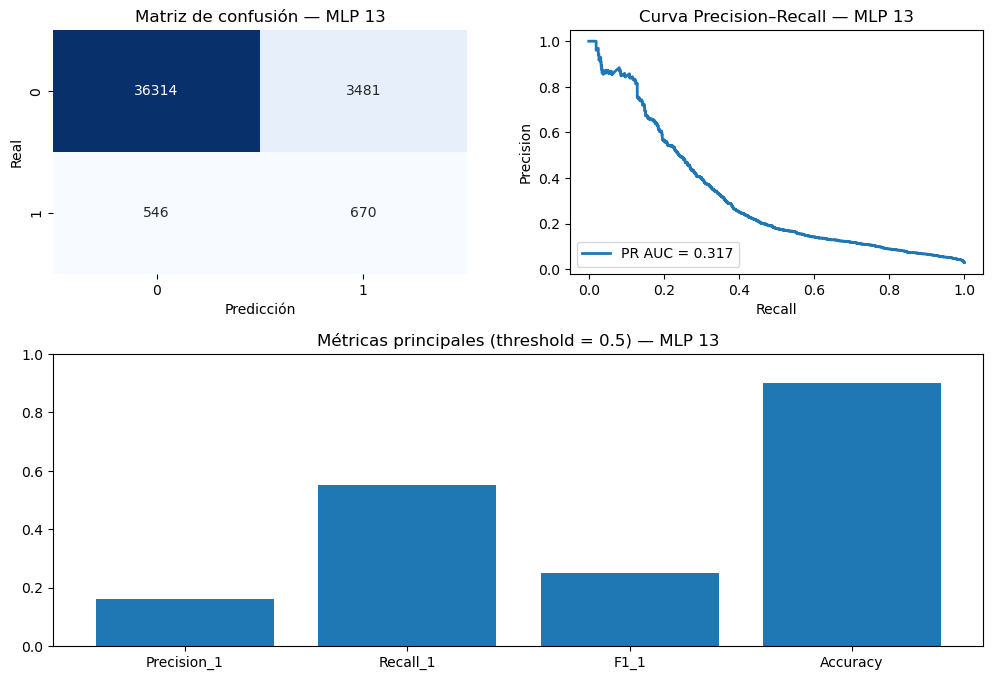

Threshold = 0.5
Precision (clase 1): 0.1614
Recall    (clase 1): 0.5510
F1        (clase 1): 0.2497
PR AUC (Average Precision): 0.3166
Precision global: 0.9018
Tiempo de entrenamiento: 464.5123 segundos 



In [72]:
# Evaluamos en test
graficar_modelo(model13, X_test, y_test, nombre="MLP 13", threshold=0.5, train_time=train_time_MLP13)

Su entrenamiento fue bastante más rápido que el anterior, rondando los **7 minutos**. Pero el resto de métricas no superaron las expectivas, **PR AUC 0.317** y **F1 0.250**.

Concluyendo que la capa extra añadió complejidad sin aportar una mejora significativa.

### Experimento 14

Fue añadido **Batch Normalization** después de cada capa densa, con el fin de estabilizar la distribución de activaciones en todos los bloques para mejorar la convergencia y robustecer la generalización.

In [88]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, random_state=42) 
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)
input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64-32)
model14 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32,  activation="relu"),   
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1, activation="sigmoid"),
])

# Optimizador AdamW con weight decay
optimizer = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4) 

# Compilación
model14.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.03),  
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=12, restore_best_weights=True) 
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5) 

# Entrenamiento
start = time.time()

history14 = model14.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, batch_size=512,
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP14 = time.time() - start

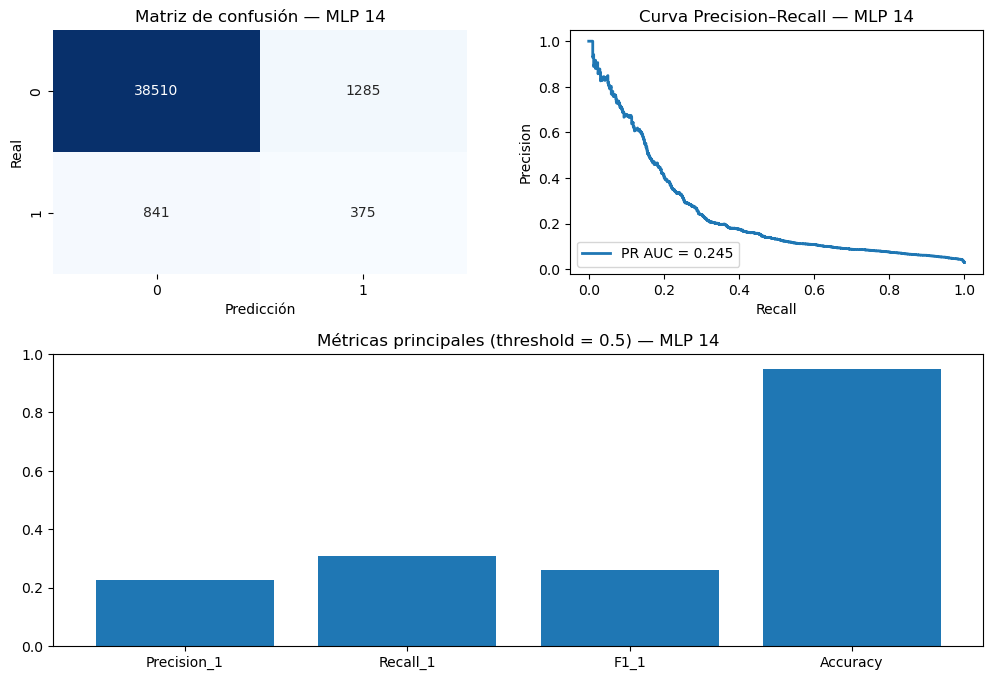

Threshold = 0.5
Precision (clase 1): 0.2259
Recall    (clase 1): 0.3084
F1        (clase 1): 0.2608
PR AUC (Average Precision): 0.2453
Precision global: 0.9482
Tiempo de entrenamiento: 366.0609 segundos 



In [89]:
# Evaluamos en test
graficar_modelo(model14, X_test, y_test, nombre="MLP 14", threshold=0.5, train_time=train_time_MLP14)

Apesar de que el **tiempo** de entrenamiento se redujo a **6 minutos**, el rendimiento fue bastante inferior, con un **PR AUC de 0.245** y **F1 de 0.260**

La normalización adicional no aportó mejoras y pudo incluso suavizar en exceso las activaciones.

### Experimento 15

Se sustituyó la función de activación ReLu por **Swish** en todas las capas, manteniendo el reso de parámetros iguales.

Esto se hizo para comprobar si mejora la propagación del gradiente y la convergencia.
    

In [110]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)


# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, random_state=42) 
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(42); np.random.seed(42)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (256-128-64-32)
model15 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation="swish"),
    layers.Dropout(0.2),
    
    layers.Dense(128, activation="swish"),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation="swish"),
    layers.Dropout(0.2),
    
    layers.Dense(32,  activation="swish"),  
    layers.Dropout(0.2),
    
    layers.Dense(1, activation="sigmoid"),
])

# Optimizador AdamW con weight decay
optimizer = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)  

# Compilación
model15.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.03),  
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=12, restore_best_weights=True) 
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5) 

# Entrenamiento
start = time.time()

history15 = model15.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, batch_size=512,
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP15 = time.time() - start

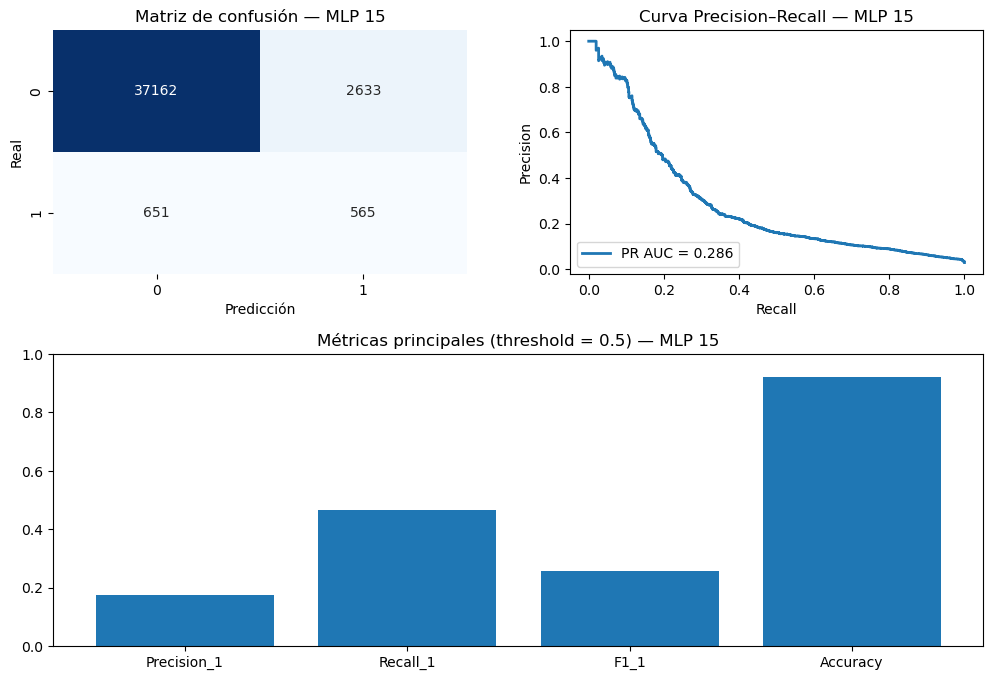

Threshold = 0.5
Precision (clase 1): 0.1767
Recall    (clase 1): 0.4646
F1        (clase 1): 0.2560
PR AUC (Average Precision): 0.2860
Precision global: 0.9199
Tiempo de entrenamiento: 570.3641 segundos 



In [111]:
# Evaluamos en test
graficar_modelo(model15, X_test, y_test, nombre="MLP 15", threshold=0.5, train_time=train_time_MLP15)

Los resultados fueron inferiores que otras pruebas, **PR AUC de 0.286** y **F1 de  0.256**. Además que el **tiempo** de entrenamiento subió a hasta **9 minutos**, uno de los mayores hasta ahora.

Con esto vemos que Swish no aporta beneficios en este dataset.

### Experimento 16

Después de todas esa pequeñas pruebas, nos quedaremos con la que mejor resultado nos dio, el experimento 12. Y en vez de cambiar su configuración habitual, cambiaremos las **semilla de producibilidad**, pasando de 42 a **7** en Numpy, TensorFlow y el random_state de SMOTE.

Estos cambios se realizaron para analizar la variabilidad del rendimiento del modelo ante diferentes semillas manteniendo constante el resto del entorno.

In [92]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, random_state=7) 
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(7); np.random.seed(7)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (512-256-128-32)
model16 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.2),
    
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    
    layers.Dense(32,  activation="relu"),  
    layers.Dropout(0.2),
    
    layers.Dense(1, activation="sigmoid"),
])

# Optimizador AdamW con weight decay
optimizer = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)  

# Compilación
model16.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.03), 
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=12, restore_best_weights=True) 
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5) 


# Entrenamiento
start = time.time()

history16 = model16.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, 
    batch_size=512,
    callbacks=[early, rlrop],
    verbose=0
)

train_time_MLP16 = time.time() - start

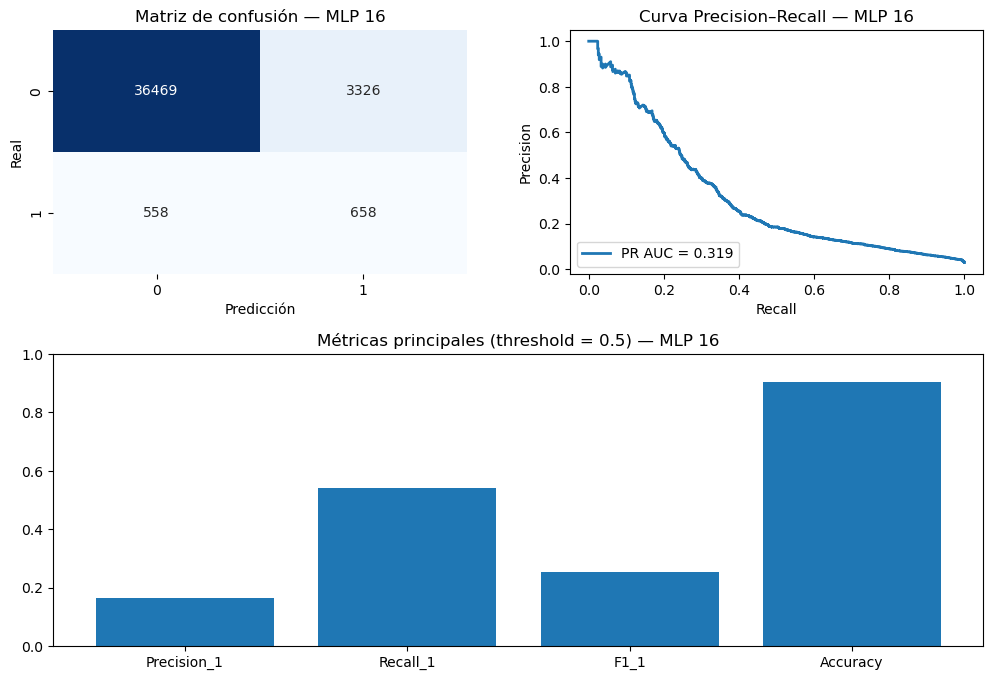

Threshold = 0.5
Precision (clase 1): 0.1652
Recall    (clase 1): 0.5411
F1        (clase 1): 0.2531
PR AUC (Average Precision): 0.3186
Precision global: 0.9053
Tiempo de entrenamiento: 437.3170 segundos 



In [93]:
# Evaluamos en test
graficar_modelo(model16, X_test, y_test, nombre="MLP 16", threshold=0.5, train_time=train_time_MLP16)

El modelo alcanzó un **PR AUC de 0.319** y un **F1 de 0.253** bastante similar al orginal pero con una ligera disminución en la capacidad discrimantiva, y tanto el recall como la precisión se mantuvieron parecidos. Sin embargo el **tiempo** de entrenamiento fue bastante menor pasando de rondar los 12 minutos a **7 minutos**.

Esto sugiere que las semillas aleatorias tuvieron un impacto menor en el rendimiento general, pero sí influyeron en la velocidad de convergencia, posiblemente debido a una inicialización de pesos más favorable o a una distribución distinta de los ejemplos sintéticos generados por SMOTE.

### Experimento 17

En esta última prueba también modificamos las semillas de reproducibilidad para terminar de comprobar si pueden mejorar todavía la capacidad de generalización, cambiamos las semillas a **123**.

In [104]:
# División en train y validación real (sin SMOTE)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

# Aplicar SMOTE solo al sub-train
sm = SMOTE(sampling_strategy=0.4, random_state=123) 
X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# Reproducibilidad
tf.random.set_seed(123); np.random.seed(123)

input_dim = X_tr_res.shape[1] # número de features

# Modelo MLP (512-256-128-32)
model17 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32,  activation="relu"),   
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

# Optimizador AdamW con weight decay
optimizer = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)  

# Compilación
model17.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.03), 
    metrics=[
        keras.metrics.AUC(curve="PR", name="pr_auc"),
        keras.metrics.AUC(curve="ROC", name="roc_auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

# Callbacks (Early Stopping + ReduceLROnPlateau) 
early = EarlyStopping(monitor="val_pr_auc", mode="max", patience=12, restore_best_weights=True) 
rlrop = ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=5, min_lr=1e-5)

# Entrenamiento
start = time.time()

history17 = model17.fit(
    X_tr_res, y_tr_res,
    validation_data=(X_val, y_val),     
    epochs=100, 
    batch_size=512,
    callbacks=[early, rlrop],
    verbose=0
)
train_time_MLP17 = time.time() - start


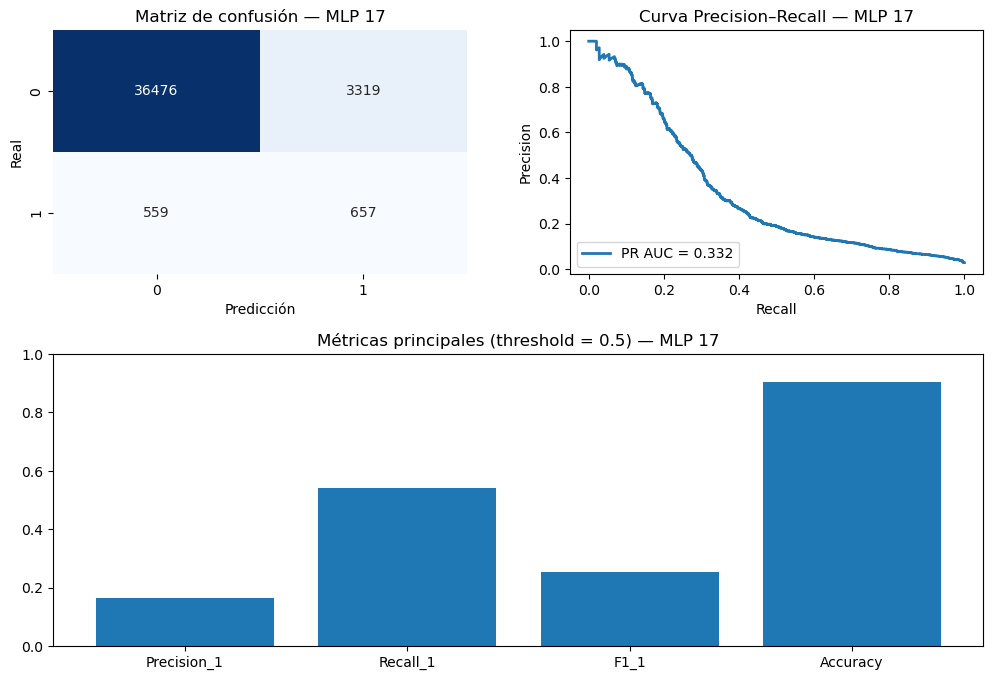

Threshold = 0.5
Precision (clase 1): 0.1652
Recall    (clase 1): 0.5403
F1        (clase 1): 0.2531
PR AUC (Average Precision): 0.3325
Precision global: 0.9054
Tiempo de entrenamiento: 657.4756 segundos 



In [105]:
# Evaluamos en test
graficar_modelo(model17, X_test, y_test, nombre="MLP 17", threshold=0.5, train_time=train_time_MLP17)

Y en este último resultado se obtuvó el modelo con mejor capacidad de generalización hasta ahora, **PR AUC de 0.332** y un **F1** estable de **0.253**, con una precisión algo baja pero un recall alto. Sin embargo, a costa de un **tiempo** de entrenamiento mayor, rondando los **11 minutos**.

El mayor tiempo pudo deberse a que no se detuvo tan pronto gracias a una trayectoria de aprendizaje más prolongada, lo que le permitió explorar mejor el espacio de parámetros y conseguir mejores resultados.


Teniendo este modelo, exploraremos cual es el umbral que le otorga mejor compromiso entre recall y precisión, y ese será elegido para otras comparaciones.

In [106]:
evaluar_modelo(model17, X_test, y_test, nombre="MLP 17", threshold=0.3, train_time=train_time_MLP17)
evaluar_modelo(model17, X_test, y_test, nombre="MLP 17", threshold=0.4, train_time=train_time_MLP17)
evaluar_modelo(model17, X_test, y_test, nombre="MLP 17", threshold=0.6, train_time=train_time_MLP17)
evaluar_modelo(model17, X_test, y_test, nombre="MLP 17", threshold=0.7, train_time=train_time_MLP17)
evaluar_modelo(model17, X_test, y_test, nombre="MLP 17", threshold=0.8, train_time=train_time_MLP17)
evaluar_modelo(model17, X_test, y_test, nombre="MLP 17", threshold=0.85, train_time=train_time_MLP17)

=== Evaluación de MLP 17 (threshold=0.3) ===
Matriz de confusión:
 [[31989  7806]
 [  315   901]]
Precision global: 0.8020
Precision (clase 1): 0.1035
Recall    (clase 1): 0.7410
F1        (clase 1): 0.1816
PR AUC (Average Precision): 0.3325
Tiempo de entrenamiento: 657.4756 segundos 

=== Evaluación de MLP 17 (threshold=0.4) ===
Matriz de confusión:
 [[34663  5132]
 [  439   777]]
Precision global: 0.8642
Precision (clase 1): 0.1315
Recall    (clase 1): 0.6390
F1        (clase 1): 0.2181
PR AUC (Average Precision): 0.3325
Tiempo de entrenamiento: 657.4756 segundos 

=== Evaluación de MLP 17 (threshold=0.6) ===
Matriz de confusión:
 [[37758  2037]
 [  662   554]]
Precision global: 0.9342
Precision (clase 1): 0.2138
Recall    (clase 1): 0.4556
F1        (clase 1): 0.2910
PR AUC (Average Precision): 0.3325
Tiempo de entrenamiento: 657.4756 segundos 

=== Evaluación de MLP 17 (threshold=0.7) ===
Matriz de confusión:
 [[38845   950]
 [  783   433]]
Precision global: 0.9577
Precision (clase